In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Define our coupled derivatives to integrate

In [47]:
def dydx(x,y):
    
    # Set the derivatives 
    
    # Our equation is d^2y/dx^2 = -y
    
    # So we can write
    # dydx = z
    # dzdx = -y
    
    # We will set y = y[0]
    # We will sey z = y[1]
    
    # Declare an array
    y_derivs = np.zeros(2)
    
    # Set dydx = x
    y_derivs[0] = y[1]
    
    # Set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    # Here we have to return the arrays of dydx
    return y_derivs

## Define the 4th order RK method

In [37]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    # Declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    # Define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    # Define x at 1 step 
    x_ipo = xi + h
    
    # Declare a temp y array
    y_temp = np.zeros(nv)
    
    # Get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    # Get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k2[:] = h*y_derivs[:]
    
    # Get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k3[:] = h*y_derivs[:]
    
    # Get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipo,y_temp)
    k4[:] = h*y_derivs[:]
    
    # Advance y by step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
    
    # THIS IS AN ARRAY
    return yipo

## Define an adaptive step size driver for RK4

In [55]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    # Define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    # Set a maximum number of iterations
    imax = 10000
    
    # Set an iteration variable
    i = 0 
    
    # Create an error 
    Delta = np.full(nv,2*tol)
    
    # Remember the step
    h_step = h
    
    # Adjust the step
    while(Delta.max()/tol > 1.0):
        
        # Estimate our error by taking one step of size h
        # vs. two steps of size h/2
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk4_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)
        
        # Compute an error
        Delta = np.fabs(y_2 - y_11)
        
        # If error is too latge, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            # Our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        # Check the iteration
        if(i>imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        # Iterate
        i += 1 
        
    # Next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    # Return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

## Define a wrapper for RK4

In [56]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    # dydx is the derivative wrt x
    # a is the lower bound
    # b is the upper bound 
    # y_a are the boundary conditions
    # tol is the tolerance for integrating y
    
    # Define our starting step
    xi = a
    yi = y_a.copy()
    
    # An initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    # Set a maximum number of iterations
    imax = 10000
    
    # Set an iteration variable
    i = 0 
    
    # Set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    # Set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    # Set a flag
    flag = 1
    
    # Loop until we reach the right side
    while(flag):
        
        # Calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        # Update the step
        h = h_new
        
        # Prevent an overshoot
        if(xi+h_step>b):
            
            # Take a smaller step
            h = b-xi
            
            # Recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            # Break
            flag = 0
        
        # Update values
        xi += h_step
        yi[:] = yi_new[:]
    
        # Add the step to the arrays 
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
    
        # Prevent too many iterations
        if(i>=imax):
        
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
        
        # Iterate
        i += 1
    
        # Output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
    
        # Break if new xi is == b
        if(xi==b):
            flag = 0

    # Return the answer
    return x,y

## Perform the integration 

In [57]:
a = 0.0
b = 2.0 * np.pi 

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

# Perform the integration 
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.46816761	h = 0.14709684	b=6.28318531
i =  11	x = 0.60535502	h = 0.13718741	b=6.28318531
i =  12	x = 0.74522296	h = 0.13986794	b=6.28318531
i =  13	x = 0.88873209	h = 0.14350913	b=6.28318531
i =  14	x = 1.02700188	h = 0.13826979	b=6.28318531
i =  15	x = 1.16350434	h = 0.13650247	b=6.28318531
i =  16	x = 1.29828215	h = 0.13477781	b=6.28318531
i =  17	x = 1.43207856	h = 0.13379641	b=6.28318531
i =  18	x = 1.56536018	h = 0.13328163	b=6.28318531
i =  19	x = 1.69861470	h = 0.13325451	b=6.28318531
i =  20	x = 1.83231473	h = 0.13

## Plot the result 

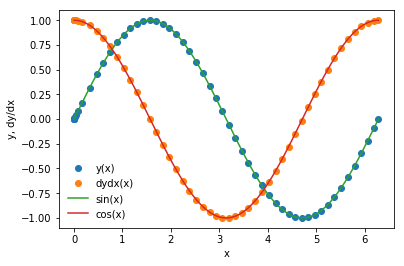

In [58]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

## Plot the error
#### Notice that the errors will actually exceed our "tolerance"

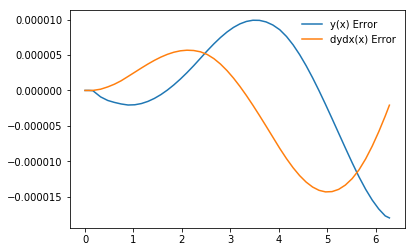

In [59]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)